# Baseline Models: Dummy Classifier & Logistic Regression

## Objective
Establish strong baseline performance for credit card fraud detection under extreme class imbalance.

This notebook:
- Uses **DummyClassifiers** as sanity checks
- Trains a **class-weighted Logistic Regression**
- Evaluates models using **ROC-AUC** and **PR-AUC**
- Performs **threshold analysis** to study precision–recall trade-offs

> Accuracy is intentionally avoided as a primary metric due to severe class imbalance.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# Load processed data (from 02_preprocessing)
X_train = np.load("../data/processed/v1_train_test/X_train_scaled.npy")
X_test  = np.load("../data/processed/v1_train_test/X_test_scaled.npy")
y_train = np.load("../data/processed/v1_train_test/y_train.npy")
y_test  = np.load("../data/processed/v1_train_test/y_test.npy")


In [4]:
def evaluate_classifier(name, y_true, y_pred, y_proba):
    print(f"\n=== {name} ===")
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("PR-AUC :", average_precision_score(y_true, y_proba))
    print("Confusion Matrix [ [TN FP], [FN TP] ]:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))


## Dummy Classifier (Most Frequent)

This model always predicts the majority class (non-fraud).
It serves as a **sanity check** and establishes the *absolute minimum* performance.


In [6]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred  = dummy.predict(X_test)
y_proba = dummy.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))
print("\nConfusion Matrix [ [TN FP], [FN TP] ]:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))


ROC-AUC: 0.5
PR-AUC : 0.0017204452090867595

Confusion Matrix [ [TN FP], [FN TP] ]:
[[56864     0]
 [   98     0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9991     56864
           1     0.0000    0.0000    0.0000        98

    accuracy                         0.9983     56962
   macro avg     0.4991    0.5000    0.4996     56962
weighted avg     0.9966    0.9983    0.9974     56962



## Dummy Classifier (Stratified)

This model predicts classes randomly while preserving class proportions.
It simulates a **random guessing baseline** under imbalance.


In [7]:
dummy_strat = DummyClassifier(strategy="stratified", random_state=42)
dummy_strat.fit(X_train, y_train)

y_pred_s  = dummy_strat.predict(X_test)
y_proba_s = dummy_strat.predict_proba(X_test)[:, 1]

print("== Dummy (stratified) ==")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_s))
print("PR-AUC :", average_precision_score(y_test, y_proba_s))
print(confusion_matrix(y_test, y_pred_s))
print(classification_report(y_test, y_pred_s, digits=4, zero_division=0))


== Dummy (stratified) ==
ROC-AUC: 0.499173466516601
PR-AUC : 0.0017204452090867595
[[56770    94]
 [   98     0]]
              precision    recall  f1-score   support

           0     0.9983    0.9983    0.9983     56864
           1     0.0000    0.0000    0.0000        98

    accuracy                         0.9966     56962
   macro avg     0.4991    0.4992    0.4992     56962
weighted avg     0.9966    0.9966    0.9966     56962



## Dummy Baseline Summary

Both dummy models fail to detect fraud cases (TP = 0), confirming:
- Accuracy is misleading
- PR-AUC close to the fraud base rate is expected
- Any meaningful model must significantly outperform this baseline


In [8]:
evaluate_classifier("Dummy (most_frequent)", y_test, y_pred, y_proba)



=== Dummy (most_frequent) ===
ROC-AUC: 0.5
PR-AUC : 0.0017204452090867595
Confusion Matrix [ [TN FP], [FN TP] ]:
[[56864     0]
 [   98     0]]
              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9991     56864
           1     0.0000    0.0000    0.0000        98

    accuracy                         0.9983     56962
   macro avg     0.4991    0.5000    0.4996     56962
weighted avg     0.9966    0.9983    0.9974     56962



## Logistic Regression (Class-Weighted)

Logistic Regression is used as a **simple, interpretable baseline**.
Class imbalance is handled using `class_weight="balanced"`.


In [9]:
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

lr_pred  = log_reg.predict(X_test)
lr_proba = log_reg.predict_proba(X_test)[:, 1]

evaluate_classifier("Logistic Regression (balanced)", y_test, lr_pred, lr_proba)



=== Logistic Regression (balanced) ===
ROC-AUC: 0.9720834996210077
PR-AUC : 0.7189705771419241
Confusion Matrix [ [TN FP], [FN TP] ]:
[[55478  1386]
 [    8    90]]
              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



## Threshold Analysis

Different probability thresholds are evaluated to understand the
precision–recall trade-off, which is critical in fraud detection systems.


In [10]:
thresholds = [0.1, 0.2, 0.3, 0.5]
for t in thresholds:
    lr_pred_t = (lr_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, lr_pred_t).ravel()
    recall = tp / (tp + fn) if (tp + fn) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    print(f"thr={t:.1f}  TP={tp} FP={fp} FN={fn}  precision={precision:.4f} recall={recall:.4f}")


thr=0.1  TP=93 FP=11315 FN=5  precision=0.0082 recall=0.9490
thr=0.2  TP=92 FP=5515 FN=6  precision=0.0164 recall=0.9388
thr=0.3  TP=90 FP=3201 FN=8  precision=0.0273 recall=0.9184
thr=0.5  TP=90 FP=1386 FN=8  precision=0.0610 recall=0.9184


## Precision–Recall Curve

The PR curve is the most informative visualization for imbalanced classification problems.


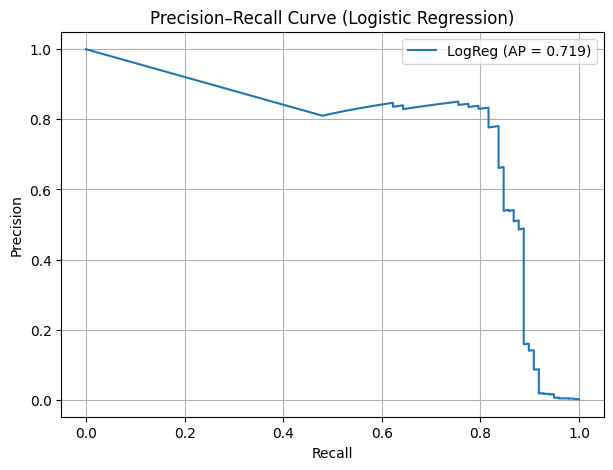

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, lr_proba)
ap = average_precision_score(y_test, lr_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"LogReg (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()


## ROC Curve

ROC-AUC is included for completeness but interpreted cautiously due to class imbalance.


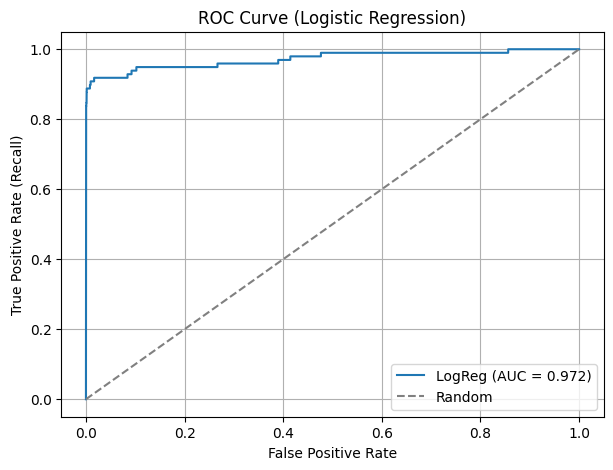

In [13]:
fpr, tpr, _ = roc_curve(y_test, lr_proba)
roc_auc = roc_auc_score(y_test, lr_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()


## Key Takeaways

- Dummy models confirm the severity of class imbalance.
- Logistic Regression achieves strong ranking performance (high PR-AUC).
- Precision–recall trade-offs must be tuned via threshold selection.
- This baseline motivates the use of non-linear ensemble models.
